Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 2  
Due: May 2, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
wd = "/mnt/Backups/jmhu"

data_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/data/"
model_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/models/"
fig_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/figures/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

if not os.path.exists(fig_dir):
    !mkdir $fig_dir

In [4]:
df = pd.read_csv(data_dir+"population_data.csv"
                )

In [5]:
df.head()

,Year,Hare,Lynx
0,1845,20,32
1,1847,20,50
2,1849,52,12
3,1851,83,10
4,1853,64,13


### Question 1. Develop a DMD model to forecast the future population states

#### Set-up

In [48]:
X=df.Hare.values[:-1]
Y=df.Lynx.values[:-1]

X=np.expand_dims(X, 1)
Y=np.expand_dims(Y, 1)

Xprime=df.Hare.values[1:]
Yprime=df.Lynx.values[1:]

Xprime=np.expand_dims(Xprime, 1)
Yprime=np.expand_dims(Yprime, 1)

print(X.shape, Xprime.shape, Y.shape, Yprime.shape)

(29, 1) (29, 1) (29, 1) (29, 1)


In [45]:
def DMD(X,Xprime,r):
    '''Dynamic Mode Decomposition Function from book'''
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    return Phi, Lambda, b

#### Run DMD

In [69]:
r=3
Phi_X, Lambda_X, b_X = DMD(X, Xprime, r)
Phi_Y, Lambda_Y, b_Y = DMD(Y, Yprime, r)

print(b_X.shape, Phi_X.shape, Lambda_X.shape)
print(b_Y.shape, Phi_Y.shape, Lambda_Y.shape)

(1,) (29, 1) (1, 1)
(1,) (29, 1) (1, 1)


#### Forecast population sizes - need help here

In [53]:
def forecast(Phi, Lambda, t, b):
    return(int(np.array(Phi*np.exp(Lambda*t)*b).squeeze()))

hares_dmd=[]
lynx_dmd=[]

years = df.Year.values

# Calculate DMD-derived populations
for t in range(len(years)):
    hares_dmd.append(forecast(Phi_X, Lambda_X, t, b_X))
    lynx_dmd.append(forecast(Phi_Y, Lambda_Y, t, b_Y))
    
# Convert to arrays and remove singleton dimensions
hares_dmd = np.array([int(h) for h in hares_dmd]).squeeze()
lynx_dmd = np.array([int(l) for l in lynx_dmd]).squeeze()

TypeError: only size-1 arrays can be converted to Python scalars

In [63]:
t=0
Phi_X[t]*b_X, Phi_X[t]*np.exp(Lambda_X*t)*b_X

(array([26.78201147]), array([[26.78201147]]))

In [65]:
t=1
Phi_X[t]*b_X, (Phi_X[t]*np.exp(Lambda_X*t)*b_X).squeeze()

(array([69.63322981]), array(146.93815623))

In [66]:
t=30
Phi_X[t]*b_X, (Phi_X[t]*np.exp(Lambda_X*t)*b_X).squeeze()

IndexError: index 30 is out of bounds for axis 0 with size 29

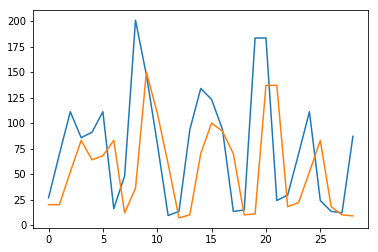

In [59]:
plt.plot(Phi_X*b_X)
plt.plot(X)

#### Population at time 0

In [10]:
t=0
print(forecast(Phi_X, Lambda_X, t, b_X), "hares")
print(forecast(Phi_Y, Lambda_Y, t, b_Y), "lynx")

19 hares
31 lynx


#### Population at time 1

In [11]:
t=1
print(forecast(Phi_X, Lambda_X, t, b_X), "hares")
print(forecast(Phi_Y, Lambda_Y, t, b_Y), "lynx")

42 hares
70 lynx


#### Population at time 20

In [12]:
t=20
print(forecast(Phi_X, Lambda_X, t, b_X), "hares")
print(forecast(Phi_Y, Lambda_Y, t, b_Y), "lynx")

61290183 hares
213076956 lynx


#### Population at time 31

In [13]:
t=31
print(forecast(Phi_X, Lambda_X, t, b_X), "hares")
print(forecast(Phi_Y, Lambda_Y, t, b_Y), "lynx")

226406783606 hares
1206143726304 lynx


### Question 2.  Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables.

In [14]:
X=df.Hare.values
Y=df.Lynx.values

from scipy.linalg import hankel

# Construct Hankel matrix
H_X = hankel(X)
H_Y = hankel(Y)

print(H_X.shape, H_Y.shape)

(30, 30) (30, 30)


21
20


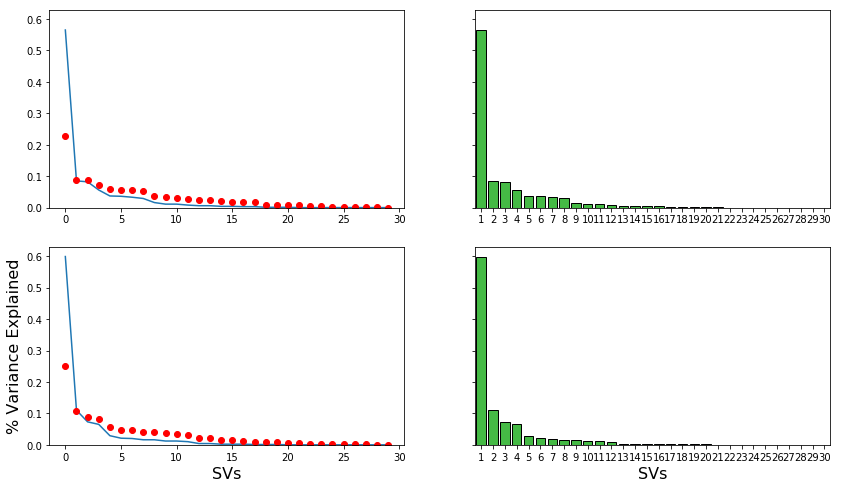

In [34]:
import seaborn as sns

# Take SVD of H_X
u, s, v = np.linalg.svd(H_X)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))

fig, ax = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
ax[0,0].plot(var_explained)
ax[0,0].plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");
ax[1,0].set_xlabel('SVs', fontsize=16)
ax[1,0].set_ylabel('% Variance Explained', fontsize=16)
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax[0,1])

# Take SVD of H_Y
u, s, v = np.linalg.svd(H_Y)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))
ax[1,0].plot(var_explained)
ax[1,0].plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");


sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax[1,1])
plt.xlabel('SVs', fontsize=16);

#### SVD of Hankel matrix shows that there are 20 and 21 non-zero modes for hare and lynx populations based on this small dataset

This suggests that there are quite a few latent variables not being measured in this dynamic system

### Question 3. Empirical Predator-Prey models such as Lotka-Volterra are commonly used to model such phenomenon. Consider the model x ̇ = (b − py)x and y ̇ = (rx − d)y. Use the data to fit values of b, p, r and d.


#### Use SINDy with limited library to fit values for b, p, r and d using the data

In [38]:
def lotka_volterra(b, p, r, d, x, y):
    '''Empirical Lotka-Volterra predator-prey model'''
    xdot = (b - p*y) * x
    ydot = (r*x - d) * y
    return(xdot, ydot)

def lotka_volterra_predator(r, d, x, y):
    '''Empirical Lotka-Volterra predator-prey model'''
    ydot = (r*x - d) * y
    return(ydot)

def lotka_volterra_prey(b, p, x, y):
    '''Empirical Lotka-Volterra predator-prey model'''
    xdot = (b - p*y) * x
    return(xdot)

In [71]:
# Set up problem
X=df.Hare.values
Y=df.Lynx.values

# Calculate derivatives with center point finite difference
xdot=np.zeros_like(X)
ydot=np.zeros_like(Y)

dt=df.Year[1]-df.Year[0]

for j in range(len(xdot)-1):
    if j == 0:
        pass
    else:
        xdot[j-1] = ( X[j+1]-X[j-1] ) / (2*dt)
        ydot[j-1] = ( Y[j+1]-Y[j-1] ) / (2*dt)
        
X.shape, Y.shape, xdot.shape, ydot.shape

((30,), (30,), (30,), (30,))

In [72]:
# Toss endpoints
X=X[1:-1]
Y=Y[1:-1]
xdot=xdot[1:-1]
ydot=ydot[1:-1]

X.shape, Y.shape, xdot.shape, ydot.shape

((28,), (28,), (28,), (28,))

In [144]:
# Create library of potential functions based on
AX = np.array([ X, X*Y])
AX_names = np.array([ "X", "XY"])

AY = np.array([ Y, X*Y])
AY_names = np.array([ "Y", "XY"])
AX.shape, len(AX_names), AY.shape, len(AY_names)

((2, 28), 2, (2, 28), 2)

In [145]:
%%time
# solve for vector xi (the weights/coefficients) using regression approach
# dx_dt = A @ xi

# # Pseudoinverse
# Xi_pinv=np.linalg.pinv(AX.T) @ xdot
# Yi_pinv=np.linalg.pinv(AY.T) @ ydot
# print(Xi_pinv.shape, Yi_pinv.shape)

from sklearn import linear_model

# LASSO
lasso=linear_model.Lasso(random_state=43, max_iter=100000000)
lasso.fit(AX.T, xdot)
Xi_lasso=lasso.coef_

lasso=linear_model.Lasso(random_state=43, max_iter=100000000)
lasso.fit(AY.T, ydot)
Yi_lasso=lasso.coef_
print(Xi_lasso.shape, Yi_lasso.shape)

# LASSO 0.8 alpha
lasso=linear_model.Lasso(random_state=43, max_iter=100000000, alpha=0.8)
lasso.fit(AX.T, xdot)
Xi_lasso8=lasso.coef_

lasso=linear_model.Lasso(random_state=43, max_iter=100000000, alpha=0.8)
lasso.fit(AY.T, ydot)
Yi_lasso8=lasso.coef_
print(Xi_lasso8.shape, Yi_lasso8.shape)

# Least Angle Regression
lars = linear_model.LassoLars()
lars.fit(AX.T, xdot)
Xi_lars=lars.coef_

lars = linear_model.LassoLars()
lars.fit(AY.T, ydot)
Yi_lars=lars.coef_
print(Xi_lars.shape, Yi_lars.shape)

(2,) (2,)
(2,) (2,)
(2,) (2,)
CPU times: user 6.62 ms, sys: 0 ns, total: 6.62 ms
Wall time: 5.71 ms


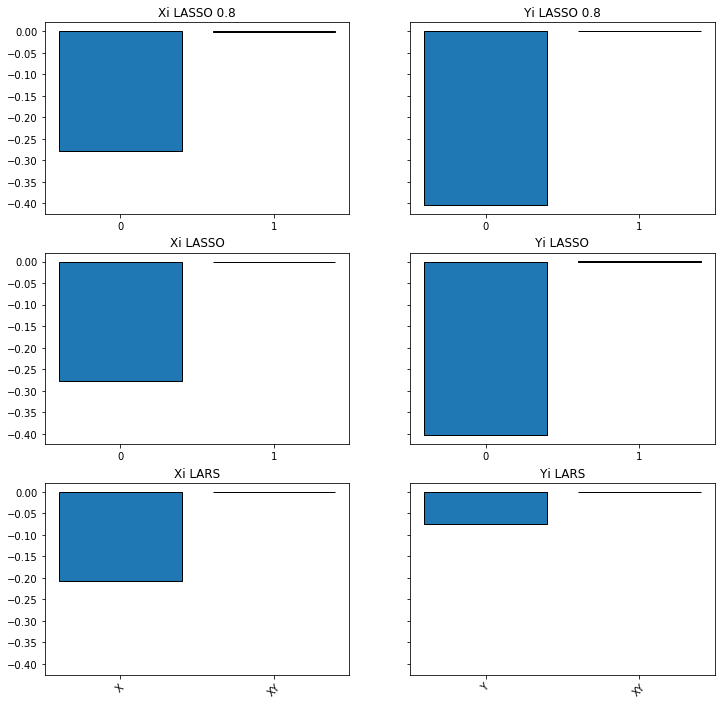

In [146]:
# Plot weightings of solutions
ec='k'

fig, ax = plt.subplots(3, 2, figsize=(12, 12), sharey=True)

# Xi 1 solutions
ax[0,0].bar(np.arange(len(AX)), Xi_lasso8, ec=ec, )
ax[1,0].bar(np.arange(len(AX)), Xi_lasso, ec=ec)
ax[2,0].bar(np.arange(len(AX)), Xi_lars, ec=ec)
ax[0,0].set_title("Xi LASSO 0.8")
ax[1,0].set_title("Xi LASSO")
ax[2,0].set_title("Xi LARS")

# Xi 2 solutions
ax[0,1].bar(np.arange(len(AY)), Yi_lasso8, ec=ec)
ax[1,1].bar(np.arange(len(AY)), Yi_lasso, ec=ec)
ax[2,1].bar(np.arange(len(AY)), Yi_lars, ec=ec)
ax[0,1].set_title("Yi LASSO 0.8")
ax[1,1].set_title("Yi LASSO")
ax[2,1].set_title("Yi LARS");

ticks=np.arange(len(AX_names))
rotation=45

ax[0,0].set_xticks(ticks)
ax[0,1].set_xticks(ticks)
ax[1,0].set_xticks(ticks)
ax[1,1].set_xticks(ticks)

ax[2,0].set_xticks(ticks)
ax[2,0].set_xticklabels(AX_names, rotation=rotation);

ax[2,1].set_xticks(ticks)
ax[2,1].set_xticklabels(AY_names, rotation=rotation);

In [149]:
# Find coefficients of LASSO and LARS (L1 normalization)
thresh=1e-3

X_coefs = [Xi_lasso8, Xi_lasso, Xi_lars]
Y_coefs = [Yi_lasso8, Yi_lasso, Yi_lars]
models = ["lasso8", "lasso", "lars"]

for xi, yi, model in zip(X_coefs, Y_coefs, models):
    print(model)
    print(xi[np.abs(xi)>thresh], AX_names[np.abs(xi)>thresh])
    print(yi[np.abs(yi)>thresh], AY_names[np.abs(yi)>thresh])    
    print("\n")

lasso8
[-0.27726079 -0.00175354] ['X' 'XY']
[-0.40454341] ['Y']


lasso
[-0.277025   -0.00175628] ['X' 'XY']
[-0.402915] ['Y']


lars
[-0.20724505] ['X']
[-0.07559126] ['Y']




**Coefficients according to lasso L1 regularization (alpha = 1):**  
b = -0.277  
p = -1.7e-3  
r = 0  
d = -0.403  

### Question 4. Find the best fit nonlinear, dynamical systems model to the data using sparse regression.

In [150]:
# Set up problem
x1=df.Hare.values
x2=df.Lynx.values

# Calculate derivatives with center point finite difference
dx1=np.zeros_like(x1)
dx2=np.zeros_like(x2)

dt=2

for j in range(len(dx1)-1):
    if j == 0:
        pass
    else:
        dx1[j-1] = ( x1[j+1]-x1[j-1] ) / (2*dt)
        dx2[j-1] = ( x2[j+1]-x2[j-1] ) / (2*dt)
        
x1.shape, x2.shape, dx1.shape, dx2.shape

((30,), (30,), (30,), (30,))

In [151]:
# Toss endpoints
x1s=x1[1:-1]
x2s=x2[1:-1]
dx1=dx1[1:-1]
dx2=dx2[1:-1]

x1s.shape, x2s.shape, dx1.shape, dx2.shape

((28,), (28,), (28,), (28,))

In [152]:
# Create library of potential functions based on
A = np.array([ x1s, x2s, x1s**2, x1s*x2s, x2s**2, 
              x1s**3, x1s*x2s**2, x1s**2*x2s, x2s**3, 
              np.sin(x1s), np.cos(x2s), np.sin(x2s), np.cos(x1s), 
              np.sin(2*x1s), np.cos(2*x2s), np.sin(2*x2s), np.cos(2*x1s),
              1/np.sin(x1s), 1/np.cos(x2s), 1/np.sin(x2s), 1/np.cos(x1s) 
             ])
A_names=["x1s", "x2s", "x1s**2", "x1s*x2s", "x2s**2", 
              "x1s**3", "x1s*x2s**2", "x1s**2*x2s", "x2s**3", 
              "np.sin(x1s)", "np.cos(x2s)", "np.sin(x2s)", "np.cos(x1s)", 
              "np.sin(2*x1s)", "np.cos(2*x2s)", "np.sin(2*x2s)", "np.cos(2*x1s)",
              "1/np.sin(x1s)", "1/np.cos(x2s)", "1/np.sin(x2s)", "1/np.cos(x1s)"
        ]
A.shape, len(A_names)

((21, 28), 21)

#### Use various solvers with L1 regularization to find function weights

In [153]:
%%time
# solve for vector xi (the weights/coefficients) using regression approach
# dx_dt = A @ xi

# Pseudoinverse
xi1_pinv=np.linalg.pinv(A.T) @ dx1
xi2_pinv=np.linalg.pinv(A.T) @ dx2
print(xi1_pinv.shape, xi2_pinv.shape)

from sklearn import linear_model

# LASSO
lasso=linear_model.Lasso(random_state=0, max_iter=100000000)
lasso.fit(A.T, dx1)
xi1_lasso=lasso.coef_

lasso=linear_model.Lasso(random_state=0, max_iter=100000000)
lasso.fit(A.T, dx2)
xi2_lasso=lasso.coef_
print(xi1_lasso.shape, xi2_lasso.shape)


# LASSO alpha = 0.8
lasso=linear_model.Lasso(random_state=0, max_iter=100000000, alpha=0.8)
lasso.fit(A.T, dx1)
xi1_lasso8=lasso.coef_

lasso=linear_model.Lasso(random_state=0, max_iter=100000000, alpha=0.8)
lasso.fit(A.T, dx2)
xi2_lasso8=lasso.coef_
print(xi1_lasso8.shape, xi2_lasso8.shape)

# Least Angle Regression
lars = linear_model.LassoLars()
lars.fit(A.T, dx1)
xi1_lars=lars.coef_

lars = linear_model.LassoLars()
lars.fit(A.T, dx2)
xi2_lars=lars.coef_
print(xi1_lars.shape, xi2_lars.shape)

(21,) (21,)
(21,) (21,)
(21,) (21,)
(21,) (21,)
CPU times: user 79.5 ms, sys: 3.72 ms, total: 83.2 ms
Wall time: 81.2 ms


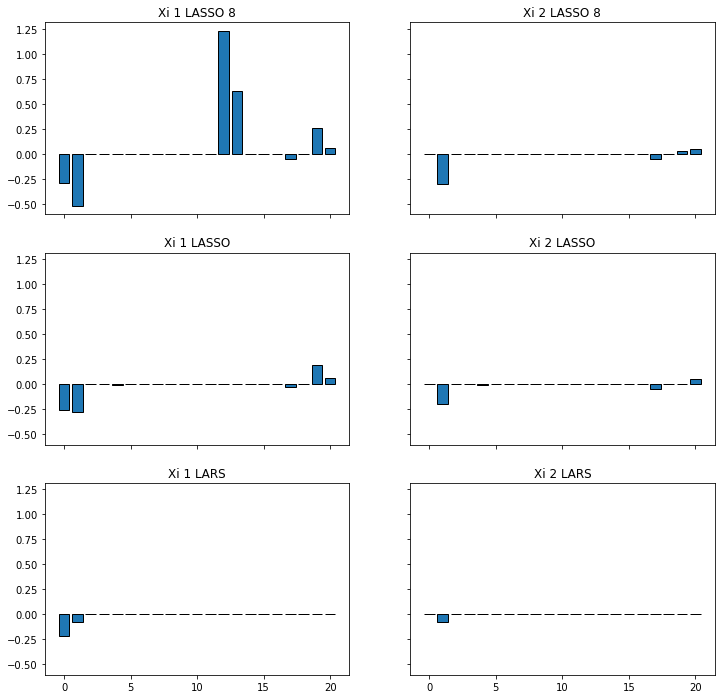

In [155]:
# Plot weightings of solutions
ec='k'

fig, ax = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)

# Xi 1 solutions
ax[0,0].bar(np.arange(len(A)), xi1_lasso8, ec=ec)
ax[1,0].bar(np.arange(len(A)), xi1_lasso, ec=ec)
ax[2,0].bar(np.arange(len(A)), xi1_lars, ec=ec)
ax[0,0].set_title("Xi 1 LASSO 8")
ax[1,0].set_title("Xi 1 LASSO")
ax[2,0].set_title("Xi 1 LARS")

# Xi 2 solutions
ax[0,1].bar(np.arange(len(A)), xi2_lasso8, ec=ec)
ax[1,1].bar(np.arange(len(A)), xi2_lasso, ec=ec)
ax[2,1].bar(np.arange(len(A)), xi2_lars, ec=ec)
ax[0,1].set_title("Xi 2 LASSO 8")
ax[1,1].set_title("Xi 2 LASSO")
ax[2,1].set_title("Xi 2 LARS");

In [156]:
# Set up candidate function tick names
A_names_sub=A_names[::2]
print(A_names_sub)

ticks=np.arange(len(A_names))
ticks=ticks[::2]
print(ticks)

['x1s', 'x1s**2', 'x2s**2', 'x1s*x2s**2', 'x2s**3', 'np.cos(x2s)', 'np.cos(x1s)', 'np.cos(2*x2s)', 'np.cos(2*x1s)', '1/np.cos(x2s)', '1/np.cos(x1s)']
[ 0  2  4  6  8 10 12 14 16 18 20]


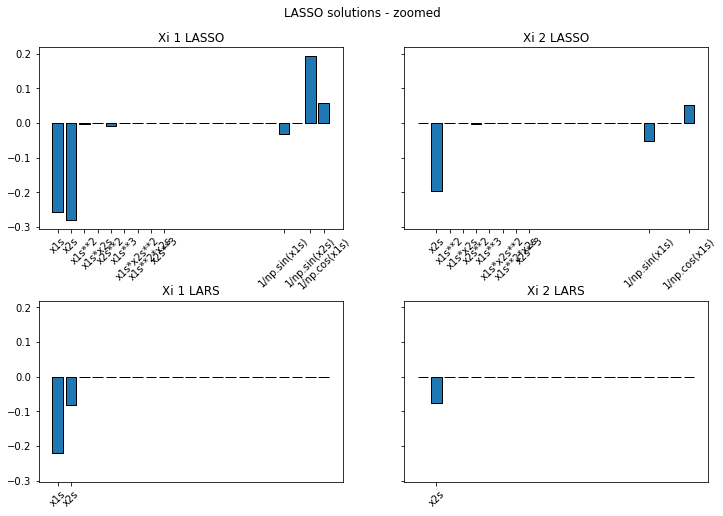

In [182]:
# Zoomed Lasso solutions
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace=0.4)

ax[0,0].bar(np.arange(len(A)), xi1_lasso, ec=ec)
ax[1,0].bar(np.arange(len(A)), xi1_lars, ec=ec)
ax[0,0].set_title("Xi 1 LASSO")
ax[1,0].set_title("Xi 1 LARS")

ax[0,1].bar(np.arange(len(A)), xi2_lasso, ec=ec)
ax[1,1].bar(np.arange(len(A)), xi2_lars, ec=ec)
ax[0,1].set_title("Xi 2 LASSO")
ax[1,1].set_title("Xi 2 LARS")

plt.suptitle("LASSO solutions - zoomed", y=0.95);

### ==== Axis ticklabels === ###
thresh=0

def good_functions(xi, thresh, A_name):
    '''First get indices of coefficients larger than threshold
    Then extract library candidate function names based on indices
    '''
    xi_ind=(np.indices(xi.shape).squeeze())[np.abs(xi)>thresh] 
    xi_names=[ A_name[x] for x in xi_ind ] 
    return(xi_ind, xi_names)

# LASSO solutions
xi1_lasso_ind, xi1_lasso_names = good_functions(xi1_lasso, thresh, A_names)
xi2_lasso_ind, xi2_lasso_names = good_functions(xi2_lasso, thresh, A_names)

# LARS solutions
xi1_lars_ind, xi1_lars_names = good_functions(xi1_lars, thresh, A_names)
xi2_lars_ind, xi2_lars_names = good_functions(xi2_lars, thresh, A_names)

rotation=45

ax[0,0].set_xticks(xi1_lasso_ind)
ax[0,0].set_xticklabels(xi1_lasso_names, rotation=rotation)

ax[0,1].set_xticks(xi2_lasso_ind)
ax[0,1].set_xticklabels(xi2_lasso_names, rotation=rotation);

ax[1,0].set_xticks(xi1_lars_ind)
ax[1,0].set_xticklabels(xi1_lars_names, rotation=rotation);

ax[1,1].set_xticks(xi2_lars_ind)
ax[1,1].set_xticklabels(xi2_lars_names, rotation=rotation);

In [188]:
# Find coefficients of LASSO and LARS (L1 normalization)
thresh=0.05

xi1_coefs = [xi1_lasso8, xi1_lasso, xi1_lars]
xi2_coefs = [xi2_lasso8, xi2_lasso, xi2_lars]
models = ["lasso8", "lasso", "lars"]

A_names=np.array(A_names)

for i, (xi1, xi2, model) in enumerate(zip(xi1_coefs, xi2_coefs, models)):
    if i == 0:
        pass
    else:
        print(model)
        print(xi1[np.abs(xi1)>thresh], A_names[np.abs(xi1)>thresh])
        print(xi2[np.abs(xi2)>thresh], A_names[np.abs(xi2)>thresh])    
        print("\n")

lasso
[-0.25564433 -0.28067634  0.19444816  0.05773681] ['x1s' 'x2s' '1/np.sin(x2s)' '1/np.cos(x1s)']
[-0.19649504 -0.05258153  0.05125806] ['x2s' '1/np.sin(x1s)' '1/np.cos(x1s)']


lars
[-0.21862302 -0.08031208] ['x1s' 'x2s']
[-0.07559126] ['x2s']




### LASSO solution takeaways and checks
Hare population dependent on:
- hare population (x1, secant(x1))
- lynx population (x2, cosecant(x2))

Lynx population dependent on:
- lynx population (x2s) ==> negatively linear wth lynx pop (more lynx, slower growth)
- hare population (secant(x1), cosecant(x1)) ==> periodic with hare population

### Thoughts

#### [SINDY](https://arxiv.org/pdf/1605.06682.pdf) *automatically* balances sparsity with model accuracy

authors said that SINDY + control worked better and SINDY alone  
dx/dt = f(x, u)

Lotka-Volterra Predator-Prey Model  
dx1/dt = ax1 - bx1x2 + u^2  
dx2/dt = -cx2 + dx1x2  
with x1 = hare population  
and x2 = lynx population

authros used u(t) = 2sin(t) + 2sin(t/10)  
using 100 timesteps (t) for training and 100 time steps (t) for validation

### Question 5.  Compute the KL divergence of the best model fit to the data between all the above models (LASSO8, LASSO, and LARS).
KL divergence = statistical metrix representing info lost when g(x) is used to represent f(x)

KL(f,g) = integral [ f(X,Beta) * log (f(X, Beta)/g(X, mu)) dX ]

[wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)  
[scipy implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html)  
see [mlm notes](https://machinelearningmastery.com/divergence-between-probability-distributions/) for discussion on kl_div() and rel_entr()  

In [ ]:
from scipy.special import rel_entr

In [ ]:
# from https://gist.github.com/swayson/86c296aa354a555536e6765bbe726ff7

def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

p = [0.1, 0.9]
q = [0.1, 0.9]

kl(p, q)

In [192]:
# Get predictions of dx1 and dx2 based on LASSO and LARS
dx1_lasso=A.T @ xi1_lasso
print(dx1_lasso.shape)
dx1_lasso

(28,)


array([-18.29265514, -20.16665608, -27.77407799, -22.60498209,
       -36.40109152, -28.18523152,  -7.88086429, -13.45904033,
       -48.82274191, -54.40738306, -34.49000094, -11.85527358,
        -5.36310996, -27.50414926, -39.37270384, -45.54089104,
       -38.72459767,  -8.01667281,   4.76118358, -50.94837285,
       -54.71407555, -15.08988022, -10.01839077, -33.0671098 ,
       -47.30579178, -18.31544944,  -7.42704657,  -7.26530825])

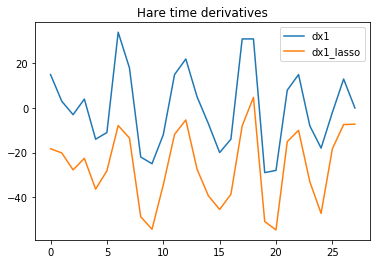

In [193]:
# Pretty close, jsut need the initial conditions to move it closer
plt.plot(dx1, label="dx1")
plt.plot(dx1_lasso, label="dx1_lasso")

plt.legend();
plt.title("Hare time derivatives");

# Need to turn this back into hares

In [ ]:
b2_lasso=A.T @ xi2_lasso
print(b2_lasso.shape)
b2_lasso

In [ ]:
# Pretty close as is
plt.plot(dx2, label="dx2")
plt.plot(b2_lasso, label="b2_lasso")
plt.legend();
plt.title("Lynx time derivatives");

## Should this be x1 and predicted x1 using b_lasso?

In [ ]:
# predicted x1 using b1_lasso will require integration
from scipy.integrate import odeint

In [ ]:
def deriv(b):
    dx_dt=
    return()

In [ ]:
odeint(b1_lasso, y0=x1[1], t=df.Year.values[1:-1])

In [ ]:
kl(x1, i=integrated)

### Question 6. Retain three of your best fit models and compare their AIC and BIC scores.

---
## Part 2 - Belousov-Zhabotinsky data

### Question 1. Download data

In [ ]:
# courses.washington.edu/amath582/BZ.mat

### Question 2. Repeat questions 1 and 2 from Part 1 using this data.

### Question 1. Find best fit nonlinear, dynamical systems model to the data using sparse regression
nonlinear = not linear  
best = lowest error, highest accuracy  
sparse = fewest model terms, (L1 regularization)  

### Question 2. Compute KL divergence of the best model fit to the data
KL divergence = statistical metrix representing info lost when g(x) is used to represent f(x)